## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe()

data_raw

,Subject1_B_cells_June_C_10 Total Intensity,Subject1_B_cells_June_C_11 Total Intensity,Subject1_B_cells_June_C_12 Total Intensity,Subject1_B_cells_June_C_13 Total Intensity,Subject1_B_cells_June_C_9 Total Intensity,Subject1_T_cells_June_D_10 Total Intensity,Subject1_T_cells_June_D_11 Total Intensity,Subject1_T_cells_June_D_12 Total Intensity,Subject1_T_cells_June_D_13 Total Intensity,Subject1_T_cells_June_D_9 Total Intensity
Protein ID,,,,,,,,,,
A0A0B4J2D5,1206607.500,1882145.4,2417132.200,3093545.2,1701011.90,301610.60,0.00,249601.9,0.0,277209.10
A0AVT1,584806.900,872883.0,1135346.800,543014.9,2131811.80,0.00,805666.10,0.0,0.0,425896.38
A0FGR8,0.000,0.0,0.000,0.0,0.00,0.00,0.00,0.0,0.0,0.00
A6NHR9,655176.100,0.0,3419854.500,0.0,0.00,105097.76,0.00,0.0,0.0,0.00
A8MWD9,696141.440,1213763.9,850701.440,1364050.2,633904.00,0.00,464729.78,0.0,0.0,446894.66
...,...,...,...,...,...,...,...,...,...,...
P43490,7249.320,0.0,112455.734,0.0,0.00,0.00,0.00,0.0,0.0,0.00
P24158,0.000,0.0,0.000,0.0,870327.56,0.00,0.00,0.0,0.0,0.00
Q8IYJ3,0.000,0.0,0.000,0.0,0.00,0.00,0.00,0.0,0.0,0.00


Before any analysis, we log normalize and median normalize across runs.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))

These are some methods that check if a value was measured or not and if the protein was measured in each type.

In [3]:
import data_utils

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [4]:
present_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, min_reps=3).dropna()
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

1_B_    76
1_T_    61
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [5]:
indecies = data_log2_normalized.apply(data_utils.check_three_of_each_type, axis=1)
data = data_log2_normalized[indecies]

In [6]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
1777
Proteins identified in at least 3 of each cell type:	
970


Now we calulate p values using a ttest. 

In [7]:
#Call ttest function
tstats = data.apply(data_utils.ttest_wrapper, axis=1)

D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [8]:
tstats['log2(B)-log2(T)'] = data.apply(data_utils.get_fold_changes, axis=1)

Fold change and p values allow us to create a volcano plot.

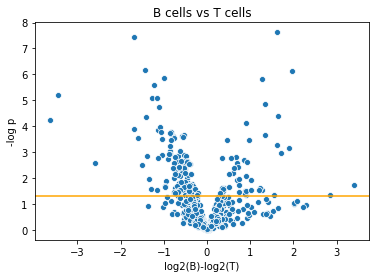

In [9]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [10]:
altered = tstats.apply(data_utils.is_altered, axis=1, change_factor=False).dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [11]:
altered.value_counts()

T cells    70
B cells    23
dtype: int64

### Figure XXX: Differentially expressed proteins

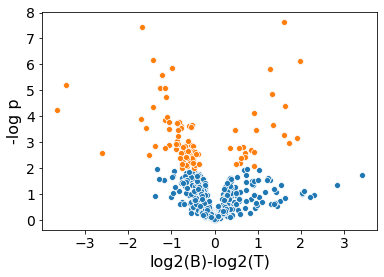

In [25]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("B cells vs T cells", fontsize=20)

#plt.savefig("data/BvsT.png", dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [13]:
protein_names = load_data.load_fasta()

In [14]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [15]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['pvalue','log2(B)-log2(T)','Name','GeneID']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [16]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type=='1_B_')]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type=='1_T_')]

### Proteins Higher in B Cells:

In [17]:
higher_in_B_cells

,pvalue,log2(B)-log2(T),Name,GeneID
Protein ID,,,,
P09960,7.507285e-07,1.968500,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4
P01834,6.875422e-04,1.903804,IGKC_HUMAN Immunoglobulin kappa constant,IGKC
P30040,1.071306e-03,1.719280,ERP29_HUMAN Endoplasmic reticulum resident pro...,ERP29
P09525,3.890927e-05,1.633878,ANXA4_HUMAN Annexin A4,ANXA4
P29350,2.368944e-08,1.619295,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6
P0DOY2,5.498670e-04,1.615894,IGLC2_HUMAN Immunoglobulin lambda constant 2,IGLC2
P27707,2.277738e-04,1.349221,DCK_HUMAN Deoxycytidine kinase,DCK
Q96KP4,1.350588e-05,1.336053,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2
P09874,1.465666e-06,1.282269,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1


### Proteins Only in B Cells:

In [18]:
B_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O15400,TX7_HUMAN Syntaxin-7,TX7
O60262,GBG7_HUMAN Guanine nucleotide-binding protein ...,GBG7
O60832,DKC1_HUMAN H/ACA ribonucleoprotein complex sub...,DKC1
O75223,GGCT_HUMAN Gamma-glutamylcyclotransferase,GGCT
O75608,LYPA1_HUMAN Acyl-protein thioesterase 1,LYPA1
...,...,...
Q16563,YPL1_HUMAN Synaptophysin-like protein 1,YPL1
Q53H96,P5CR3_HUMAN Pyrroline-5-carboxylate reductase 3,P5CR3
Q7L9L4,MOB1B_HUMAN MOB kinase activator 1B,MOB1B


### Proteins higher or only in B cells by GeneID

In [19]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

### Proteins Higher in T Cells:

In [20]:
higher_in_T_cells.sort_values('log2(B)-log2(T)',ascending=True)

,pvalue,log2(B)-log2(T),Name,GeneID
Protein ID,,,,
O14745,5.824518e-05,-3.641555,NHRF1_HUMAN Na(+)/H(+) exchange regulatory cof...,NHRF1
P26447,6.058736e-06,-3.451464,10A4_HUMAN Protein S100-A4,10A4
Q96C19,2.559636e-03,-2.604676,EFHD2_HUMAN EF-hand domain-containing protein D2,EFHD2
P31949,1.322267e-04,-1.700536,10AB_HUMAN Protein S100-A11,10AB
P12814,3.492032e-08,-1.681521,ACTN1_HUMAN Alpha-actinin-1,ACTN1
...,...,...,...,...
P59998,7.790980e-03,-0.444094,ARPC4_HUMAN Actin-related protein 2/3 complex ...,ARPC4
Q14141,2.898766e-03,-0.429436,EPT6_HUMAN Septin-6,EPT6
P15880,7.150961e-03,-0.397399,RS2_HUMAN 40S ribosomal protein S2,RS2


### Proteins Only in T Cells:

In [21]:
T_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00584,RNT2_HUMAN Ribonuclease T2,RNT2
O15117,FYB1_HUMAN FYN-binding protein 1,FYB1
O43665,RGS10_HUMAN Regulator of G-protein signaling 10,RGS10
O60496,DOK2_HUMAN Docking protein 2,DOK2
O60610,DIAP1_HUMAN Protein diaphanous homolog 1,DIAP1
...,...,...
P13164,IFM1_HUMAN Interferon-induced transmembrane pr...,IFM1
P37235,HPCL1_HUMAN Hippocalcin-like protein 1,HPCL1
Q15438,CYH1_HUMAN Cytohesin-1,CYH1


### Proteins higher or only in T cells by GeneID

In [22]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)